In [1]:
from autometrics.dataset.datasets.simplification import SimpDA
from autometrics.util.analysis import display_top_5_metrics_by_validation, get_top_metric_by_validation, plot_metric_target_scatterplot
from autometrics.generator.LLMJudgeRubricProposer import LLMJudgeRubricProposer
from autometrics.aggregator.regression import Ridge
from autometrics.metrics.MetricBank import all_metrics
import dspy
from prometheus_eval.litellm import LiteLLM
import litellm
import pandas as pd
pd.set_option('display.max_columns', None)

litellm.suppress_debug_info = True

/opt/miniconda3/envs/auto_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = SimpDA()

In [3]:
dataset.add_metrics(all_metrics)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 41/41 [02:28<00:00,  3.63s/it]


computing greedy matching.


100%|██████████| 68/68 [00:00<00:00, 123.40it/s]


done in 149.54 seconds, 29.02 sentences/sec


In [4]:
train, dev, test = dataset.get_splits(train_ratio=0.2, val_ratio=0.3, seed=42)

In [5]:
llama31_70b = dspy.LM("openai/meta-llama/Meta-Llama-3.1-70b-Instruct", api_base="http://future-hgx-1:7410/v1", api_key="None")

dspy.settings.configure(lm=llama31_70b)

In [6]:
llama31_70b_litellm = LiteLLM('openai/meta-llama/Meta-Llama-3.1-70b-Instruct', api_base="http://future-hgx-1:7410/v1", api_key='None') # VLLM endpoint

In [7]:
generator = LLMJudgeRubricProposer(train_dataset=train, task_description="Given a complicated original sentence, simplify it in a way such that a broader audience could easily understand it.", proposer_model=llama31_70b, judge_model=llama31_70b)

In [8]:
llama31_70b.model

'openai/meta-llama/Meta-Llama-3.1-70b-Instruct'

In [9]:
new_metrics = []

for target_column in dataset.target_columns:
    new_metrics.extend(generator.generate(train, target_column, use_prometheus=False))

In [10]:
# Condense the metrics that have duplicate names
new_metrics_names = set()
new_metrics_final = []
for metric in new_metrics:
    if metric.name not in new_metrics_names:
        new_metrics_names.add(metric.name)
        new_metrics_final.append(metric)

In [11]:
for metric in new_metrics_final:
    metric.display()

,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Simplification of vocabulary**: The model's ability to replace complex vocabulary with simpler alternatives.,"A score of 1 indicates that the model fails to simplify complex vocabulary. The output text contains the same complex words and phrases as the original text, making it difficult for a broader audience to understand.","A score of 2 indicates that the model attempts to simplify complex vocabulary but does so incorrectly. The output text contains oversimplified or inaccurate replacements of complex words and phrases, which can alter the original meaning.","A score of 3 indicates that the model partially simplifies complex vocabulary. The output text contains some simplified words and phrases, but others remain complex. The model shows some understanding of simplification but lacks consistency.","A score of 4 indicates that the model successfully simplifies most complex vocabulary. The output text contains simplified words and phrases that maintain the original meaning. However, there may be some minor errors or instances where complex vocabulary is not fully simplified.","A score of 5 indicates that the model excels at simplifying complex vocabulary. The output text contains accurate and effective simplifications of complex words and phrases, making it easily understandable by a broader audience. The model demonstrates a strong ability to identify and replace complex vocabulary while preserving the original meaning."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Simplification of sentence structure**: The model's ability to break down complex sentence structures into simpler ones.,"A score of 1 indicates that the model's output is not simplified at all, and may even be more complex than the original sentence. The output may contain grammatical errors, and the meaning may be lost or distorted.","A score of 2 indicates that the model's output shows some attempt at simplification, but it is not effective. The output may still be overly complex, and the meaning may be partially lost. Some grammatical errors may be present.","A score of 3 indicates that the model's output is partially simplified, but there is still room for improvement. The output may contain some complex sentence structures, and the meaning may be mostly preserved. Some minor grammatical errors may be present.","A score of 4 indicates that the model's output is well-simplified, with clear and concise language. The meaning is preserved, and the sentence structure is simplified. There may be some minor errors in grammar or vocabulary choice.","A score of 5 indicates that the model's output is excellently simplified, with clear and concise language that preserves the original meaning. The sentence structure is simplified, and there are no grammatical errors. The output is easy to understand and free of unnecessary complexity."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Conveyance of intended meaning**: The model's ability to convey the intended meaning of the original sentence in the simplified output.,"A score of 1 indicates that the simplified sentence fails to convey the intended meaning of the original sentence. The simplified sentence may be incomplete, inaccurate, or misleading, resulting in a significant loss of information or a change in the intended meaning.","A score of 2 indicates that the simplified sentence partially conveys the intended meaning of the original sentence. While some information is preserved, the simplified sentence may lack important details, contain inaccuracies, or have a different tone than the original sentence.","A score of 3 indicates that the simplified sentence generally conveys the intended meaning of the original sentence. The simplified sentence may lack some nuances or details, but it accurately captures the main information and tone of the original sentence.","A score of 4 indicates that the simplified sentence effectively conveys the intended meaning of the original sentence. The simplified sentence is accurate, complete, and preserves the tone and context of the original sentence, with only minor losses of information or nuances.","A score of 5 indicates that the simplified sentence perfectly conveys the intended meaning of the original sentence. The simplified sentence is accurate, complete, and preserves the tone, context, and all nuances of the original sentence, demonstrating a high level of understanding and preservation of the intended meaning."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Grammatical correctness**: The model's ability to produce grammatically correct output sentences.,"A score of 1 is given when the output sentence is completely ungrammatical, making it difficult or impossible to understand. The sentence may lack a clear subject-verb-object structure, contain multiple grammatical errors, or be missing essential words or phrases.","A score of 2 is given when the output sentence contains significant grammatical errors that hinder its clarity and readability. The sentence may have a clear subject-verb-object structure, but contains errors in verb tense, subject-verb agreement, or word order.","A score of 3 is given when the output sentence contains some grammatical errors, but is still understandable. The sentence may have a clear subject-verb-object structure, but contains errors in punctuation, word choice, or sentence structure.","A score of 4 is given when the output sentence is mostly grammatically correct, but contains minor errors that do not significantly impact its clarity. The sentence may have a clear subject-verb-object structure, but contains small errors in verb tense, subject-verb agreement, or word order.","A score of 5 is given when the output sentence is perfectly grammatical, clear, and well-formed. The sentence has a clear subject-verb-object structure, correct verb tense, subject-verb agreement, and word order, and is free of grammatical errors."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Preservation of original meaning**: The ability of the model to preserve the original meaning of the sentence while simplifying it.,A score of 1 indicates that the simplified sentence has completely lost the original meaning. The output is either unrelated to the original sentence or introduces new information that changes the intended meaning.,"A score of 2 indicates that the simplified sentence has partially lost the original meaning. While some core information is preserved, significant details or nuances are missing, or the output introduces minor inaccuracies that affect the overall meaning.","A score of 3 indicates that the simplified sentence has mostly preserved the original meaning, but with some minor issues. The output may lack some details or contain minor inaccuracies, but the core information and intended meaning are still intact.","A score of 4 indicates that the simplified sentence has well-preserved the original meaning. The output accurately conveys the core information and intended meaning, with only minor and insignificant deviations from the original sentence.","A score of 5 indicates that the simplified sentence has perfectly preserved the original meaning. The output is a clear, concise, and accurate representation of the original sentence, with no loss of information or changes to the intended meaning."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Simplification of language**: The model's capacity to rephrase complex sentences using simpler vocabulary and sentence structures.,"A score of 1 indicates that the simplified text is completely unrelated to the original sentence or is grammatically incorrect, making it impossible to understand.","A score of 2 indicates that the simplified text is partially related to the original sentence but contains significant errors in grammar, vocabulary, or sentence structure, making it difficult to understand.","A score of 3 indicates that the simplified text is somewhat related to the original sentence but lacks clarity and precision, with some errors in grammar, vocabulary, or sentence structure.","A score of 4 indicates that the simplified text is mostly related to the original sentence, with minor errors in grammar, vocabulary, or sentence structure, but still conveys the main idea.","A score of 5 indicates that the simplified text is a clear, accurate, and concise rephrasing of the original sentence, using simpler vocabulary and sentence structures while preserving the original meaning."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,**Contextual understanding**: The model's ability to comprehend the context in which the original sentence is being used and adapt the simplified sentence accordingly.,A score of 1 indicates that the model has failed to demonstrate any understanding of the context. The simplified sentence is either completely unrelated to the original sentence or is so inaccurate that it conveys a different meaning altogether.,"A score of 2 indicates that the model has shown some limited understanding of the context, but the simplified sentence is still inaccurate or incomplete. The model may have captured some aspects of the original sentence, but has failed to convey the full meaning or has introduced errors that change the context.","A score of 3 indicates that the model has demonstrated a moderate level of contextual understanding. The simplified sentence is generally accurate, but may lack some nuances or details that are present in the original sentence. The model has captured the main idea, but may not have fully conveyed the context.","A score of 4 indicates that the model has demonstrated a strong understanding of the context. The simplified sentence is accurate and conveys the main idea of the original sentence, including most of the nuances and details. The model has successfully adapted the sentence to the context, making it clear and easy to understand.","A score of 5 indicates that the model has demonstrated an exceptional understanding of the context. The simplified sentence is not only accurate but also conveys the full meaning and nuances of the original sentence. The model has perfectly adapted the sentence to the context, making it clear, concise, and easy to understand."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,"**Accuracy of details**: The model's attention to detail in preserving specific information, such as names, dates, and locations.","A score of 1 indicates that the model's output is severely lacking in accuracy, with most details altered or omitted. The output may be difficult to understand or may not convey the same meaning as the original sentence.","A score of 2 indicates that the model's output is somewhat inaccurate, with some details altered or omitted. While the output may still convey the general meaning of the original sentence, it may contain errors or inaccuracies that affect its overall understanding.","A score of 3 indicates that the model's output is moderately accurate, with some details preserved but others altered or omitted. The output may convey the general meaning of the original sentence, but may contain some errors or inaccuracies.","A score of 4 indicates that the model's output is mostly accurate, with most details preserved but some minor errors or inaccuracies. The output conveys the same meaning as the original sentence, but may contain some slight deviations.","A score of 5 indicates that the model's output is highly accurate, with all details preserved and no errors or inaccuracies. The output conveys the same meaning as the original sentence, and is virtually identical in terms of specific information."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,"**Coherence and fluency**: The model's ability to produce outputs that are grammatically correct, easy to read, and free of ambiguities.","A score of 1 indicates that the output is incoherent and difficult to read. The output may contain multiple grammatical errors, be poorly structured, and lack clarity. The language may be awkward, and the sentence structure may be confusing. The output may also lack proper punctuation, capitalization, and spelling.","A score of 2 indicates that the output is somewhat incoherent and difficult to read. The output may contain some grammatical errors, be poorly structured, and lack clarity. The language may be awkward, and the sentence structure may be confusing. However, the output may still be understandable with some effort.","A score of 3 indicates that the output is neutral in terms of coherence and fluency. The output may contain some minor grammatical errors, but the language is generally clear and easy to understand. The sentence structure may be somewhat awkward, but the output is still readable.","A score of 4 indicates that the output is coherent and fluent. The output may contain some minor errors, but the language is clear and easy to understand. The sentence structure is generally good, and the output is well-organized and easy to read.","A score of 5 indicates that the output is highly coherent and fluent. The output is free of grammatical errors, and the language is clear and concise. The sentence structure is excellent, and the output is well-organized and easy to read. The output is engaging and enjoyable to read."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,Clarity: The ability of the simplified sentence to clearly convey the information from the original sentence.,"A score of 1 is given when the simplified sentence is completely unclear or does not convey any information from the original sentence. The sentence may be incomplete, grammatically incorrect, or lack any meaningful connection to the original sentence.","A score of 2 is given when the simplified sentence is somewhat unclear or only partially conveys the information from the original sentence. The sentence may be missing key details, contain grammatical errors, or be difficult to understand.","A score of 3 is given when the simplified sentence is moderately clear and conveys some of the information from the original sentence. The sentence may lack some details or contain minor errors, but overall, it provides a general understanding of the original sentence.","A score of 4 is given when the simplified sentence is clear and conveys most of the information from the original sentence. The sentence may contain minor errors or lack some nuances, but overall, it accurately conveys the main points of the original sentence.","A score of 5 is given when the simplified sentence is extremely clear and accurately conveys all the information from the original sentence. The sentence is well-written, free of errors, and provides a complete understanding of the original sentence."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,Information retention: The degree to which the simplified sentence retains the essential information from the original sentence.,"A score of 1 indicates that the simplified sentence has lost almost all the essential information from the original sentence. The simplified sentence may be unrelated to the original or may only retain a minor detail, rendering it ineffective in conveying the original message.","A score of 2 signifies that the simplified sentence retains some information from the original sentence but misses key points or distorts the original meaning. While it may capture a general idea, it lacks critical details necessary for a full understanding of the original text.",A score of 3 means the simplified sentence retains some of the essential information but may omit or alter significant details. It conveys a partial understanding of the original message but may not fully capture its nuances or key elements.,A score of 4 indicates that the simplified sentence effectively retains most of the essential information from the original sentence. It may slightly rephrase or omit minor details but generally conveys the original message accurately.,"A score of 5 signifies that the simplified sentence retains all the essential information from the original sentence, conveying the original message accurately and completely. It achieves a perfect balance between simplification and information retention."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,Readability: The ease with which the simplified sentence can be read and understood by a broader audience.,"A score of 1 indicates that the sentence is very difficult to read and understand. The language is complex, and the sentence structure is convoluted, making it challenging for most readers to comprehend. The sentence may contain jargon, technical terms, or overly complex vocabulary that limits its accessibility.","A score of 2 indicates that the sentence is somewhat difficult to read and understand. While the language is not overly complex, the sentence structure may be awkward, or the vocabulary may be somewhat specialized. The sentence may require some effort to comprehend, but it is still accessible to readers with some background knowledge of the subject matter.","A score of 3 indicates that the sentence is moderately readable. The language is clear, and the sentence structure is straightforward. The vocabulary is accessible to most readers, and the sentence is easy to understand with some basic knowledge of the subject matter. However, the sentence may still contain some minor complexities or nuances that require close attention.","A score of 4 indicates that the sentence is quite readable. The language is simple and clear, and the sentence structure is logical and easy to follow. The vocabulary is accessible to a broad range of readers, and the sentence is easy to understand with minimal effort. The sentence may still contain some minor technical terms or specialized vocabulary, but it is generally easy to comprehend.","A score of 5 indicates that the sentence is extremely readable. The language is very simple and clear, and the sentence structure is straightforward and easy to follow. The vocabulary is accessible to almost all readers, and the sentence is easy to understand with little to no effort. The sentence is free of technical terms, jargon, and complex vocabulary, making it accessible to a very broad range of readers."


,Criteria,Score 1,Score 2,Score 3,Score 4,Score 5
0,Conciseness: The ability of the simplified sentence to convey the information in a concise and efficient manner.,"A score of 1 indicates that the simplified sentence is not concise at all. It may be longer than the original sentence, or it may contain unnecessary words or phrases that do not add to the meaning of the sentence. The sentence may also be unclear or confusing, making it difficult to understand the intended meaning.","A score of 2 indicates that the simplified sentence is somewhat concise, but it still contains some unnecessary words or phrases. The sentence may be a bit clearer than a score of 1, but it still requires some effort to understand the intended meaning. The sentence may also lack clarity or precision, making it difficult to convey the intended information.","A score of 3 indicates that the simplified sentence is fairly concise, but it may still contain some minor flaws. The sentence may be clear and easy to understand, but it may not be as direct or efficient as possible. The sentence may also contain some unnecessary words or phrases that do not add to the meaning.","A score of 4 indicates that the simplified sentence is very concise and effective. The sentence is clear, direct, and easy to understand, and it conveys the intended information in a efficient manner. The sentence may contain a few minor flaws, but overall it is well-written and effective.","A score of 5 indicates that the simplified sentence is extremely concise and effective. The sentence is clear, direct, and easy to understand, and it conveys the intended information in a very efficient manner. The sentence is well-written, precise, and free of unnecessary words or phrases."


In [12]:
train.add_metrics(new_metrics_final)
dev.add_metrics(new_metrics_final)
test.add_metrics(new_metrics_final)

Processing Items: 100%|██████████| 82/82 [00:00<00:00, 466.93it/s]
/Users/michaelryan/Documents/School/Stanford/Research/autometrics/autometrics/metrics/llm_judge/LLMJudgeRubricDSPy.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.name] = results
Processing Items: 100%|██████████| 82/82 [00:00<00:00, 901.24it/s]
/Users/michaelryan/Documents/School/Stanford/Research/autometrics/autometrics/metrics/llm_judge/LLMJudgeRubricDSPy.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.name] = 

In [13]:
print(new_metrics_final)

[Simplification of vocabulary_Meta-Llama-3.1-70b-Instruct_rubric: **Simplification of vocabulary**: The model's ability to replace complex vocabulary with simpler alternatives., Simplification of sentence structure_Meta-Llama-3.1-70b-Instruct_rubric: **Simplification of sentence structure**: The model's ability to break down complex sentence structures into simpler ones., Conveyance of intended meaning_Meta-Llama-3.1-70b-Instruct_rubric: **Conveyance of intended meaning**: The model's ability to convey the intended meaning of the original sentence in the simplified output., Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric: **Grammatical correctness**: The model's ability to produce grammatically correct output sentences., Preservation of original meaning_Meta-Llama-3.1-70b-Instruct_rubric: **Preservation of original meaning**: The ability of the model to preserve the original meaning of the sentence while simplifying it., Simplification of language_Meta-Llama-3.1-70b-Instruct

In [14]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric (0.7053643016308854),Conciseness_Meta-Llama-3.1-70b-Instruct_rubric (0.5791367161903915),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.6291583148347297),BERTScoreP_roberta-large (0.5799887010646303),Readability_Meta-Llama-3.1-70b-Instruct_rubric (0.4875561771640425)
meaning,Preservation of original meaning_Meta-Llama-3.1-70b-Instruct_rubric (0.8274184247920018),Clarity_Meta-Llama-3.1-70b-Instruct_rubric (0.776977165321399),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.7301202603500745),Information retention_Meta-Llama-3.1-70b-Instruct_rubric (0.7863691132208258),Accuracy of details_Meta-Llama-3.1-70b-Instruct_rubric (0.7603038617568123)
simplicity,Conciseness_Meta-Llama-3.1-70b-Instruct_rubric (0.708461164303083),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.5994775833368889),Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric (0.6527596434841443),BERTScoreP_roberta-large (0.6150344373913592),Clarity_Meta-Llama-3.1-70b-Instruct_rubric (0.5715349801825611)


In [15]:
from tqdm import tqdm
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.ensure_dependencies(train)
    aggregator.ensure_dependencies(dev)
    aggregator.ensure_dependencies(test)

100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


In [16]:
print(new_metrics)

[Simplification of vocabulary_Meta-Llama-3.1-70b-Instruct_rubric: **Simplification of vocabulary**: The model's ability to replace complex vocabulary with simpler alternatives., Simplification of sentence structure_Meta-Llama-3.1-70b-Instruct_rubric: **Simplification of sentence structure**: The model's ability to break down complex sentence structures into simpler ones., Conveyance of intended meaning_Meta-Llama-3.1-70b-Instruct_rubric: **Conveyance of intended meaning**: The model's ability to convey the intended meaning of the original sentence in the simplified output., Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric: **Grammatical correctness**: The model's ability to produce grammatically correct output sentences., Preservation of original meaning_Meta-Llama-3.1-70b-Instruct_rubric: **Preservation of original meaning**: The ability of the model to preserve the original meaning of the sentence while simplifying it., Simplification of language_Meta-Llama-3.1-70b-Instruct

In [17]:
train.get_metric_columns()

['BLEU',
 'CHRF',
 'TER',
 'GLEU',
 'SARI_P',
 'SARI_F',
 'BERTScoreP_roberta-large',
 'BERTScoreR_roberta-large',
 'BERTScoreF_roberta-large',
 'FKGL',
 'Simplification of vocabulary_Meta-Llama-3.1-70b-Instruct_rubric',
 'Simplification of sentence structure_Meta-Llama-3.1-70b-Instruct_rubric',
 'Conveyance of intended meaning_Meta-Llama-3.1-70b-Instruct_rubric',
 'Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric',
 'Preservation of original meaning_Meta-Llama-3.1-70b-Instruct_rubric',
 'Simplification of language_Meta-Llama-3.1-70b-Instruct_rubric',
 'Contextual understanding_Meta-Llama-3.1-70b-Instruct_rubric',
 'Accuracy of details_Meta-Llama-3.1-70b-Instruct_rubric',
 'Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric',
 'Clarity_Meta-Llama-3.1-70b-Instruct_rubric',
 'Information retention_Meta-Llama-3.1-70b-Instruct_rubric',
 'Readability_Meta-Llama-3.1-70b-Instruct_rubric',
 'Conciseness_Meta-Llama-3.1-70b-Instruct_rubric']

In [18]:
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.learn(train, target)
    aggregator.predict(train)
    aggregator.predict(dev)
    aggregator.predict(test)

100%|██████████| 3/3 [00:00<00:00,  9.00it/s]


In [19]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Rg_fluency_llm (0.6965682172746174),Rg_simplicity_llm (0.6739231566342417),Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric (0.7053643016308854),Conciseness_Meta-Llama-3.1-70b-Instruct_rubric (0.5791367161903915),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.6291583148347297)
meaning,Rg_meaning_llm (0.8424370659642049),Preservation of original meaning_Meta-Llama-3.1-70b-Instruct_rubric (0.8274184247920018),Clarity_Meta-Llama-3.1-70b-Instruct_rubric (0.776977165321399),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.7301202603500745),Rg_simplicity_llm (0.6992330586518387)
simplicity,Rg_simplicity_llm (0.7610345371058526),Rg_fluency_llm (0.682564856528945),Conciseness_Meta-Llama-3.1-70b-Instruct_rubric (0.708461164303083),Rg_meaning_llm (0.6566869626063747),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.5994775833368889)


In [20]:
display_top_5_metrics_by_validation(test, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Grammatical correctness_Meta-Llama-3.1-70b-Instruct_rubric (0.7053643016308854),Rg_fluency_llm (0.6965682172746174),Rg_simplicity_llm (0.6739231566342417),Coherence and fluency_Meta-Llama-3.1-70b-Instruct_rubric (0.6291583148347297),Rg_meaning_llm (0.6259666712097682)
meaning,Rg_meaning_llm (0.8424370659642049),Preservation of original meaning_Meta-Llama-3.1-70b-Instruct_rubric (0.8274184247920018),Conveyance of intended meaning_Meta-Llama-3.1-70b-Instruct_rubric (0.8130745521025878),Information retention_Meta-Llama-3.1-70b-Instruct_rubric (0.7863691132208258),Contextual understanding_Meta-Llama-3.1-70b-Instruct_rubric (0.7848564768937564)
simplicity,Rg_simplicity_llm (0.7610345371058526),Conciseness_Meta-Llama-3.1-70b-Instruct_rubric (0.708461164303083),Rg_fluency_llm (0.682564856528945),Simplification of language_Meta-Llama-3.1-70b-Instruct_rubric (0.6603122885895881),Contextual understanding_Meta-Llama-3.1-70b-Instruct_rubric (0.6577011503200084)


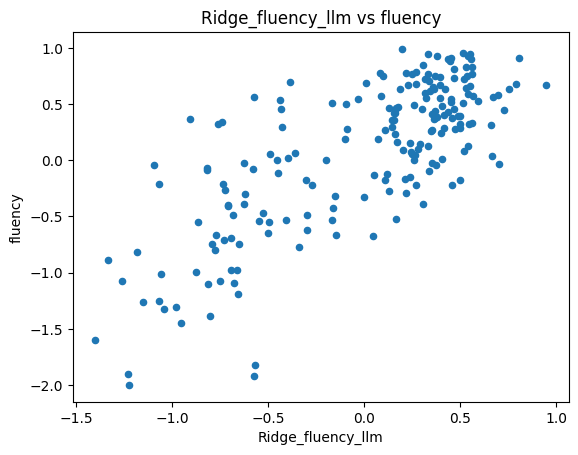

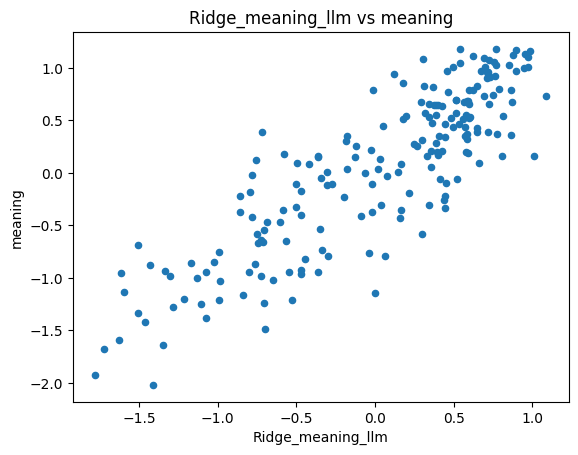

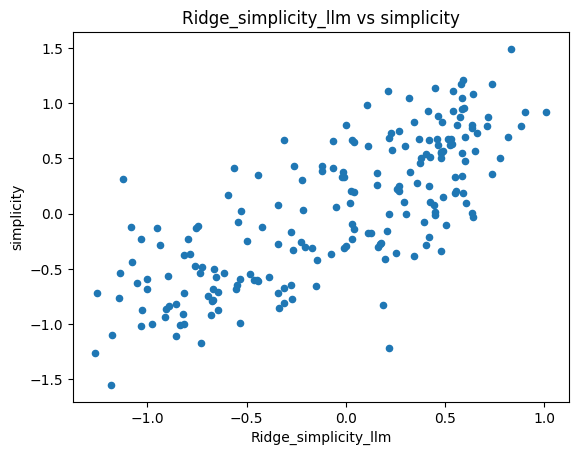

In [21]:
for target_column in dataset.target_columns:
    metric = get_top_metric_by_validation(dev, target_column, True)
    plot_metric_target_scatterplot(test, metric, target_column)
